In [289]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLars, LassoLarsIC
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold
import pandas as pd
import pickle
from numpy import *
import numpy as np
import os
from scipy.stats.mstats import zscore
import pandas as pd
import nibabel as nib 
from nilearn.plotting import plot_img,plot_glass_brain
import os
from nilearn.plotting import plot_glass_brain

from funcs import *


%pylab inline

%load_ext autoreload 
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


# Params

In [2]:
## PARAMS ##

base_dir = '/home/nick/Desktop/dki_stuff/modalities/'
classes = [('cons','CON'),('pats','PAT')]
mask_path = '/home/nick/Desktop/dki_stuff/code/masks/white.nii'

###########

# Mask visualization

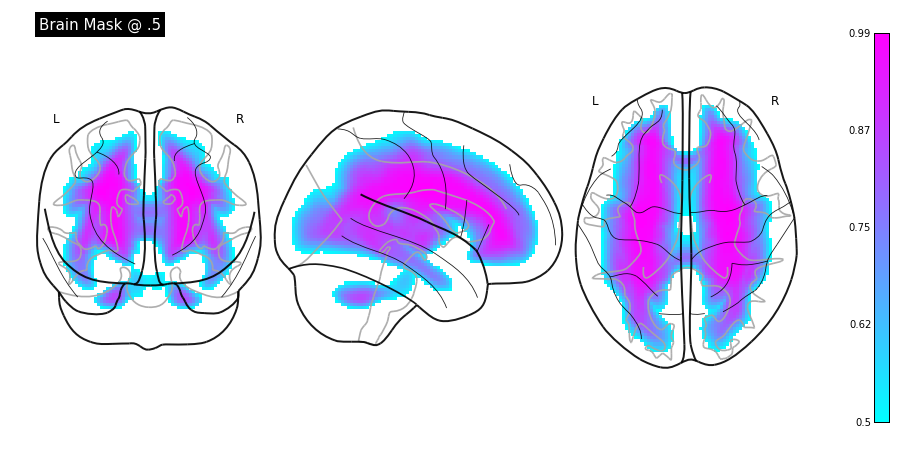

In [3]:
fig = figure(figsize=(12,6))
plot_glass_brain(nib.load(mask_path),
                 threshold=.5,
                 colorbar=True,
                 title='Brain Mask @ .5',
                 cmap=plt.cm.cool,alpha=.9,
                 figure = fig
                )
plt.show()

#Loading data

In [4]:
# grabbing dmean and fa for testing 
dfa = load_db(base_dir,classes).ix[['dmean','kmean','fa']]
dfa

,cons,pats
dmean,[/home/nick/Desktop/dki_stuff/modalities/dmean...,[/home/nick/Desktop/dki_stuff/modalities/dmean...
kmean,[/home/nick/Desktop/dki_stuff/modalities/kmean...,[/home/nick/Desktop/dki_stuff/modalities/kmean...
fa,[/home/nick/Desktop/dki_stuff/modalities/fa/fa...,[/home/nick/Desktop/dki_stuff/modalities/fa/fa...


# applying mask

In [5]:
## applying mask to matrices
# masked_matrices = mask_dataframe(dfa,mask_path)
masked_matrices = pd.read_pickle('/home/nick/Desktop/dki_stuff/masked_matrices.pickle')
masked_matrices

,cons,pats
dmean,"[[0.900367, 0.929843, 0.892926, 0.920383, 0.87...","[[0.947932, 0.997482, 0.966199, 0.994236, 0.93..."
fa,"[[0.193831, 0.233026, 0.21176, 0.266958, 0.191...","[[0.159587, 0.201227, 0.169772, 0.196879, 0.16..."
kmean,"[[0.890155, 0.896358, 0.915954, 0.90995, 0.946...","[[0.907448, 0.916198, 0.943497, 0.947185, 0.92..."


# z-scoring and mag div

In [148]:
results_df = pd.DataFrame(columns=['results_mean','alpha','C','gamma','n_features','mode'])
results_df

,results_mean,alpha,C,gamma,n_features,mode


# Running Lasso FC outside GridSearch Dmean
* To change modality, set mode below 
 * variable mode must be a list, can contain multiple modalities 
 
We obtained our best results here with : 
<table style="width:40%">
  <tr>
    <td><b>Modality</b></td>
    <td><b>Alpha</b></td> 
    <td><b>Gamma</b></td>
  </tr>
  <tr>
    <td>dmean</td>
    <td>.01</td> 
    <td>8.286</td>
  </tr>
    <tr>
    <td>kmean</td>
    <td>.01</td> 
    <td>15</td>
  </tr>
    <tr>
    <td>fa</td>
    <td>.00001</td> 
    <td>0.15</td>
  </tr>
      <tr>
    <td>dmean & kmean</td>
    <td>0.0001</td> 
    <td>1</td>
  </tr>    <tr>
    <td>dmean & fa</td>
    <td>.001</td> 
    <td>1</td>
    
  </tr>
      <tr>
    <td>kmean & fa</td>
    <td>0.0001</td> 
    <td>1</td>
    
  </tr>
        <tr>
    <td>all 3</td>
    <td>0.00001</td> 
    <td>1</td>
    
  </tr>
  
</table>


In [351]:
mode = ['dmean']
mat = build_matrix(masked_matrices,mode)

29502833


In [ ]:
y_labels_vector = build_y(masked_matrices,mode)
x_input = zscore_mag_div_matrix(mat)
print x_input.shape

# Search Range

In [307]:
alpha_range = [.01,.001]
gamma_range = [1,8]

In [308]:
n_cpus = 1
print x_input.shape


for al in alpha_range:
    
    print 'running alpha : {}'.format(al)
    
    x_input_to_svc,_ = lasso_feature_selection(np.copy(x_input), y_labels_vector, al)

    if np.count_nonzero(x_input_to_svc) > 0:
        svc_pipe = Pipeline([('svc', SVC(C=1))])

        gridsearcher = GridSearchCV(svc_pipe, 
                            param_grid=dict(svc__gamma=gamma_range),
                            cv= StratifiedKFold(y_labels_vector,6),
                            verbose=6,
                            n_jobs=n_cpus
                           )
        gridsearcher.fit(x_input_to_svc,y_labels_vector)
        for g in gridsearcher.grid_scores_:
            gg =  [g[1],al,1,g[0]['svc__gamma'],np.count_nonzero(w),mode]
            results_df.loc[ len(results_df) ] = gg
    else:
        print '0 features selected at alpha {} ; not running'.format(al)






(68, 435702)
running alpha : 0.01
Weights Shape : (435702,)
20 positive coefficients @ alpha = 0.01
20 positive coefficients @ alpha = 0.01
Fitting 6 folds for each of 2 candidates, totalling 12 fits
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=1.000000 -   5.4s
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=0.833333 -   5.6s
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=0.909091 -   5.7s
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=1.000000 -   5.4s
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=0.909091 -   5.1s
[CV] svc__gamma=1 ....................................................
[CV] ..............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.4min finished



running alpha : 0.001
Weights Shape : (435702,)
17 positive coefficients @ alpha = 0.001
17 positive coefficients @ alpha = 0.001
Fitting 6 folds for each of 2 candidates, totalling 12 fits
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=1.000000 -   4.8s
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=0.833333 -   4.7s
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=0.909091 -   5.3s
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=0.909091 -   5.3s
[CV] svc__gamma=1 ....................................................
[CV] ........................... svc__gamma=1, score=0.909091 -   4.8s
[CV] svc__gamma=1 ....................................................
[CV] .......................

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.3min finished


# Dmean Results

In [309]:
results_df.sort('results_mean').head(5)

,results_mean,alpha,C,gamma,n_features,mode
2,0.882353,0.001,1,1,16,[dmean]
3,0.897059,0.001,1,8,16,[dmean]
0,0.911765,0.010,1,1,16,[dmean]
1,0.911765,0.010,1,8,16,[dmean]


Max Performance : 0.91176


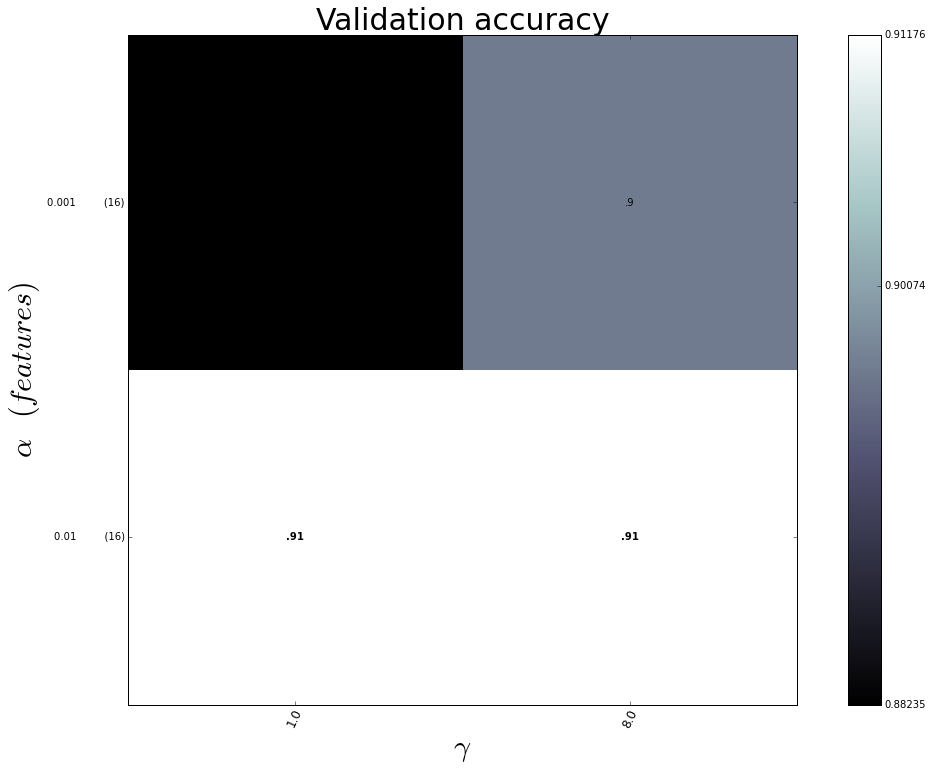

In [310]:

imshow_data(results_df)

# Visualizing feature selection for best Lasso score

In [232]:
resampled_mask = create_mask(nib.load('/home/nick/Desktop/dki_stuff/code/masks/white.nii'),
                   nib.load('/home/nick/Desktop/dki_stuff/modalities/dmean/dmeanCON001.nii')
                  )


In [281]:
_,coefs = lasso_feature_selection(x_input,y_labels_vector,.01)

Weights Shape : (435702,)
20 positive coefficients @ alpha = 0.01
20 positive coefficients @ alpha = 0.01


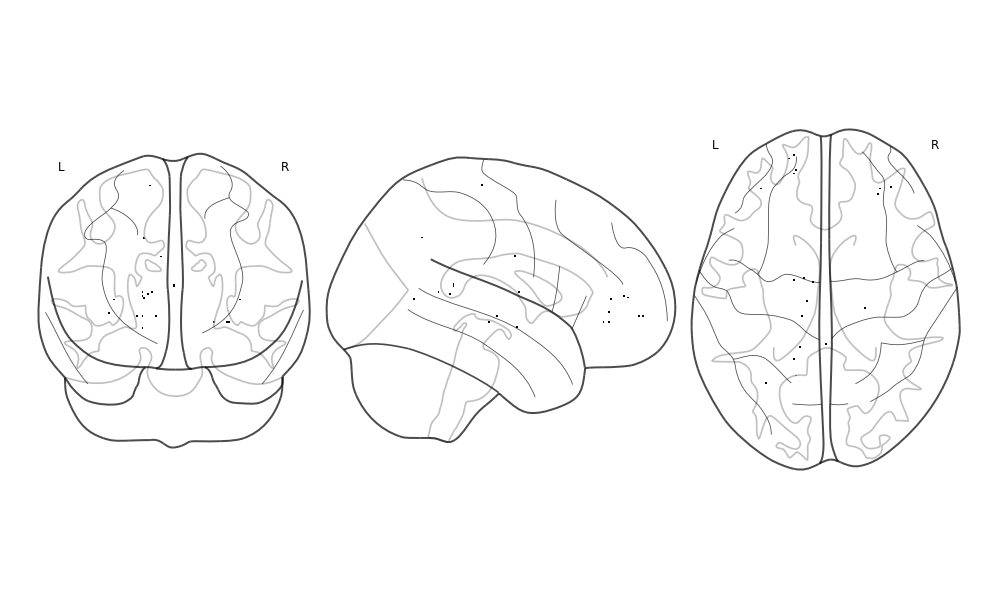

In [286]:
fig = figure(figsize=(13,8))

plot_glass_brain(coefs_mask(coefs,resampled_mask),cmap='hot',figure=fig)
show()

# adding Lasso to the cross-validation

In [290]:
alpha_range = [.01,.001]
gamma_range = [1,8]

score_matrix = np.zeros((6,len(alpha_range),len(gamma_range)))

cv = StratifiedKFold(y_labels_vector,6)
y = y_labels_vector
X = x_input
fold = 0
for train, test in cv:
    y_test = y[test]
    X_test = X[test]
    
    y_train = y[train]
    X_train = X[train]
    for alpha_it, alpha in enumerate(alpha_range):
        ls = Lasso(alpha,copy_X=True,max_iter=1e5)
        ls.fit(X_train,y_train)
        w = MakeBinary(ls.coef_)
        np.nonzero(w)
        print '{} features selected @ alpha : {}'.format(np.count_nonzero(w),alpha)

        X_train_w = X_train * w
        X_test_w = X_test * w 

        for gamma_it ,gamma in enumerate(gamma_range):
            svc = SVC(gamma = gamma)
            svc.fit(X_train_w,y_train)
            y_test_pred = svc.predict( X_test_w )
            score = f1_score( y_test , y_test_pred )
            score_matrix[ fold, alpha_it, gamma_it ] = score
            print '| fold : {:>6} | alpha : {:>6} | gamma : {:>6} |  score : {:>5} % '.format(fold,alpha,gamma,round(score*100,2))

    fold += 1

   

11 features selected @ alpha : 0.01
| fold :      0 | alpha :   0.01 | gamma :      1 |  score : 100.0 % 
| fold :      0 | alpha :   0.01 | gamma :      8 |  score : 92.31 % 
16 features selected @ alpha : 0.001
| fold :      0 | alpha :  0.001 | gamma :      1 |  score : 100.0 % 
| fold :      0 | alpha :  0.001 | gamma :      8 |  score : 92.31 % 
13 features selected @ alpha : 0.01
| fold :      1 | alpha :   0.01 | gamma :      1 |  score : 83.33 % 
| fold :      1 | alpha :   0.01 | gamma :      8 |  score : 83.33 % 
17 features selected @ alpha : 0.001
| fold :      1 | alpha :  0.001 | gamma :      1 |  score : 83.33 % 
| fold :      1 | alpha :  0.001 | gamma :      8 |  score : 92.31 % 
12 features selected @ alpha : 0.01
| fold :      2 | alpha :   0.01 | gamma :      1 |  score :  75.0 % 
| fold :      2 | alpha :   0.01 | gamma :      8 |  score : 88.89 % 
13 features selected @ alpha : 0.001
| fold :      2 | alpha :  0.001 | gamma :      1 |  score : 88.89 % 
| fold :   

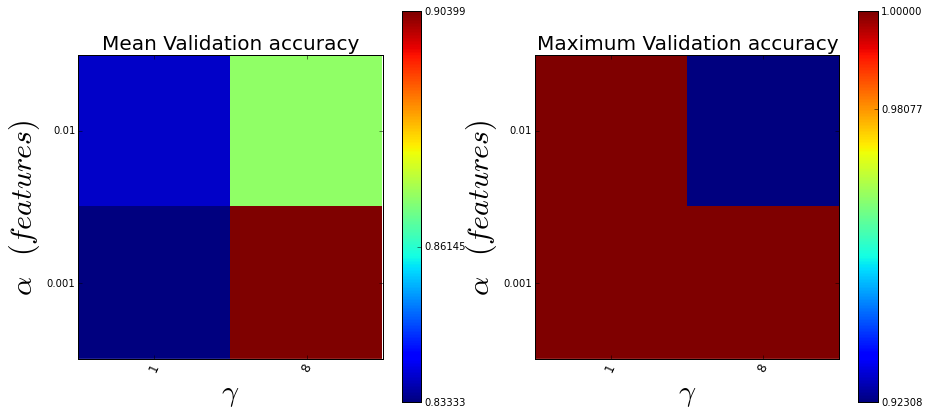

In [294]:
rcParams['axes.titlesize']=  20
plt.figure(figsize=(15,7))
plt.subplot(121)
mean_scores = np.mean(score_matrix,axis=0)
cax = imshow(mean_scores,interpolation='none')
cbar = plt.colorbar(cax, ticks=[np.min(mean_scores), np.mean(mean_scores), np.max(mean_scores)])
plt.xticks(np.arange(len(gamma_range)),gamma_range, rotation=65)
plt.yticks(np.arange(len(alpha_range)),alpha_range)
plt.ylabel(r'$\alpha\;(features)$')
plt.title('Mean Validation accuracy')
plt.xlabel(r'$\gamma$')
plt.subplot(122)

max_scores = np.max(score_matrix,axis=0)
cax = imshow(max_scores,interpolation='none')
cbar = plt.colorbar(cax, ticks=[np.min(max_scores), np.mean(max_scores), np.max(max_scores)])
plt.xticks(np.arange(len(gamma_range)),gamma_range, rotation=65)
plt.yticks(np.arange(len(alpha_range)),alpha_range)
plt.ylabel(r'$\alpha\;(features)$')
plt.title('Maximum Validation accuracy')
plt.xlabel(r'$\gamma$')


In [301]:
coeffs = np.zeros(X.shape[1])
# print coeffs.shape
selected_voxels=[]
cv = StratifiedKFold(y,6)
for train, val in cv:
    y_val = y[val]
    X_val = X[val]
    
    y_train = y[train]
    X_train = X[train]

    ls = Lasso(.001,copy_X=True)
    ls.fit(X_train,y_train)
    w = MakeBinary(ls.coef_)
    coeffs[np.nonzero(w)] += 1
    print np.count_nonzero(w)
    selected_voxels.append(np.nonzero(w))


16
17
13
15
15
16


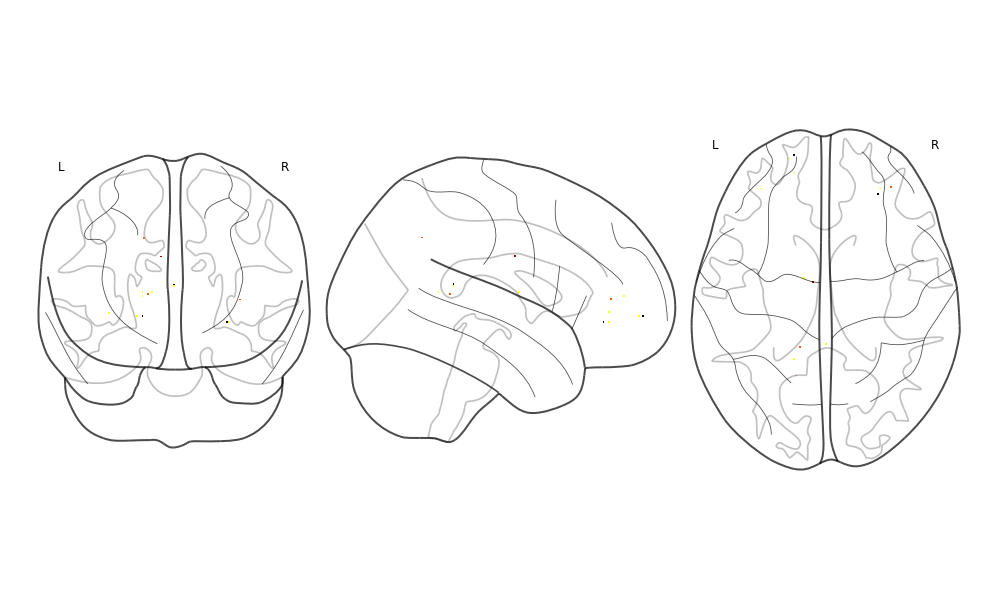

In [302]:
fig = figure(figsize=(13,8))
plot_glass_brain(coefs_mask(coeffs,resampled_mask),cmap='hot',figure=fig)
show()

In [303]:
score_matrix = np.zeros(6)


cv = StratifiedKFold(y,6)
def do_cv(train,test):
    y_test = y[test]
    X_test = X[test]
    
    y_train = y[train]
    X_train = X[train]
    params = []
    cv2 = StratifiedKFold(y_train,6)
    for train2, test2 in cv2:
        y_train2 = y_train[train2]
        X_train2  = X_train[train2]

        y_test2 = y_train[test2]
        X_test2 = X_train[test2]

        for alpha_it, alpha in enumerate(alpha_range):
                ls = Lasso(alpha,copy_X=True,max_iter=1e5)
                ls.fit(X_train2,y_train2)
                w = MakeBinary(ls.coef_)
                np.nonzero(w)
                print '{} features selected @ alpha : {}'.format(np.count_nonzero(w),alpha)

                X_train_w = X_train2 * w
                X_test_w = X_test2 * w 

                for gamma_it ,gamma in enumerate(gamma_range):
                    svc = SVC(gamma = gamma)
                    svc.fit(X_train_w,y_train2)
                    y_test_pred = svc.predict( X_test_w )
                    score = f1_score( y_test2 , y_test_pred )
                    #score_matrix[ fold, alpha_it, gamma_it ] = score
                    params.append( (score,alpha,gamma) )
#                     print '| alpha : {:>6} | gamma : {:>6} |  score : {:>5} % '.format(alpha,gamma,round(score*100,2))
    params = sorted(params,key = lambda x: x[0])[::-1][0]
    print params
    ls = Lasso(params[1],copy_X=True,max_iter=1e5)
    ls.fit(X_train,y_train)
    w = MakeBinary(ls.coef_)
    X_train_w = X_train * w
    X_test_w = X_test * w
    svc = SVC(gamma = params[2])
    svc.fit(X_train_w,y_train)
    y_test_pred = svc.predict(X_test_w)
    return ( f1_score(y_test,y_test_pred) , params ,w)
    

In [305]:
from joblib import Parallel, delayed
# parallel function
## save paths of masked data
scoresss = Parallel(n_jobs=1,verbose=50)(
                    delayed(do_cv)(train,test) for train, test in cv)
   

12 features selected @ alpha : 0.01
15 features selected @ alpha : 0.001
13 features selected @ alpha : 0.01
13 features selected @ alpha : 0.001
12 features selected @ alpha : 0.01
12 features selected @ alpha : 0.001
12 features selected @ alpha : 0.01
13 features selected @ alpha : 0.001
12 features selected @ alpha : 0.01
13 features selected @ alpha : 0.001
17 features selected @ alpha : 0.01
14 features selected @ alpha : 0.001
(1.0, 0.001, 8)
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  2.3min
12 features selected @ alpha : 0.01
15 features selected @ alpha : 0.001
12 features selected @ alpha : 0.01
14 features selected @ alpha : 0.001
12 features selected @ alpha : 0.01
13 features selected @ alpha : 0.001
10 features selected @ alpha : 0.01
15 features selected @ alpha : 0.001
11 features selected @ alpha : 0.01
15 features selected @ alpha : 0.001
9 features selected @ alpha : 0.01
13 features selected @ alpha : 0.001
(1.0, 0.001, 8)
[Parallel(n_jobs=1)]: Done   2 j

In [319]:
for s in scoresss:
    print '| full score : {:>15} | inner score {:>5} | alpha : {:>5} | gamma : {:>5} |'.format(s[0],*s[1])
print '\n| mean score : {:>5} |'.format(np.mean([s[0] for s in scoresss]))

| full score :  0.923076923077 | inner score   1.0 | alpha : 0.001 | gamma :     8 |
| full score :  0.923076923077 | inner score   1.0 | alpha : 0.001 | gamma :     8 |
| full score :  0.888888888889 | inner score   1.0 | alpha :  0.01 | gamma :     8 |
| full score :             1.0 | inner score   1.0 | alpha : 0.001 | gamma :     8 |
| full score :  0.888888888889 | inner score   1.0 | alpha : 0.001 | gamma :     8 |
| full score :             0.8 | inner score   1.0 | alpha : 0.001 | gamma :     8 |


In [340]:
s = [np.nonzero(s[2]) for s in scoresss]
s = [item for sublist in s for item in sublist]
s = [item for sublist in s for item in sublist] 

print len(s) /6
print len(np.unique(s))

15
20


In [326]:
coefs = [s[2] for s in scoresss]
zzz = np.zeros(len(coefs[0]))
for c in coefs:
    zzz += c

Populating the interactive namespace from numpy and matplotlib


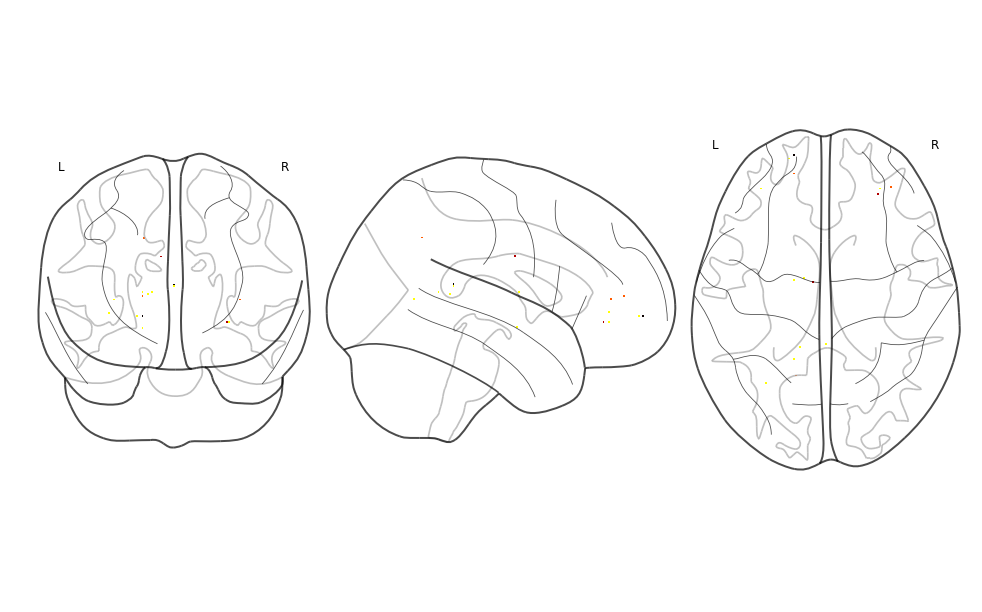

In [344]:
%pylab inline
fig = figure(figsize=(13,8))
plot_glass_brain(coefs_mask(zzz,resampled_mask),cmap='hot',figure=fig,colormap=True)
show()

In [347]:
mat = build_matrix(masked_matrices,mode)

x_input == zscore_mag_div_matrix(mat) 

x
x
x
x
x
x
x
x
x


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [349]:
print count_nonzero(x_input)

1360
